In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import linear_model
import statsmodels.api as sm
from DLtools.Data import load_data
from DLtools.evaluation_rec import real_eva_error, error_rec


In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Load data

In [3]:
# # r='data/instant_data/rain_small.csv'
# # w='data/instant_data/water_small.csv'
# # rw = load_data(r,w)
# # df =rw.df.resample('d').mean().astype('float32')
# # data =df.interpolate(limit=30).fillna(0)
# # TARGET= 'CPY015_w' # target station
loaddata = load_data()
ame = loaddata.df_rain
kawa = loaddata.df_water
tenki = loaddata.df_weather
dam = loaddata.df_dam

df_d = loaddata.daily()
df_h = loaddata.hourly()


  5%|▍         | 7/154 [00:00<00:02, 51.18it/s]START LOADING DATA 2012-2020(July)

rainfall (daily)....
356
Working on rain file.....
  0%|          | 0/113 [00:00<?, ?it/s]
Before del col are... 154
After... 123

water lv (hourly)....
149
Working on water file.....
100%|██████████| 113/113 [04:15<00:00,  2.26s/it]

Before del col are... 113
After... 94

weather lv (hourly)....
355
working on Weather year 2012
100%|██████████| 1842/1842 [00:08<00:00, 204.74it/s]
(11987808,) temp
(11987808,) press
(11987808,) humid
(11987808,) solar
(11987808,) rain1h

Before del col are... 990
After... 252

Dam (daily)....
working on column: WaterVol
working on column: Useable_WaterVol
working on column: Input_WaterVol
working on column: Output_WaterVol

Before del col are... 20
After... 20
==========TOTAL FILE==========
Rain.............Water.........Weather...........Dam
(2769, 123) (398736, 94) (66456, 252) (2745, 20)


# Feature selection

In [4]:
def high_corr(data,threshold=.95):
    """Eliminate first columns with high corr"""
    
    corr_matrix = data.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop

In [5]:
def corr_w_Y(data,target,threshold= 0.3):
    # correlation 
    corr_test = data.corr(method='pearson')[target]
    corr_test = corr_test[(corr_test> threshold) | (corr_test< -threshold) ]
    corr_test = corr_test.sort_values(ascending=False)
    #corr_test =corr_test[1:] # eliminate Target it own
    return corr_test

In [39]:
data=df_d["2013-01-01":"2017-12-31"].interpolate(limit=360).fillna(0)
TARGET = 'CPY015_wl'

col_feature = corr_w_Y(data,TARGET,0.5).index
data = data[col_feature]

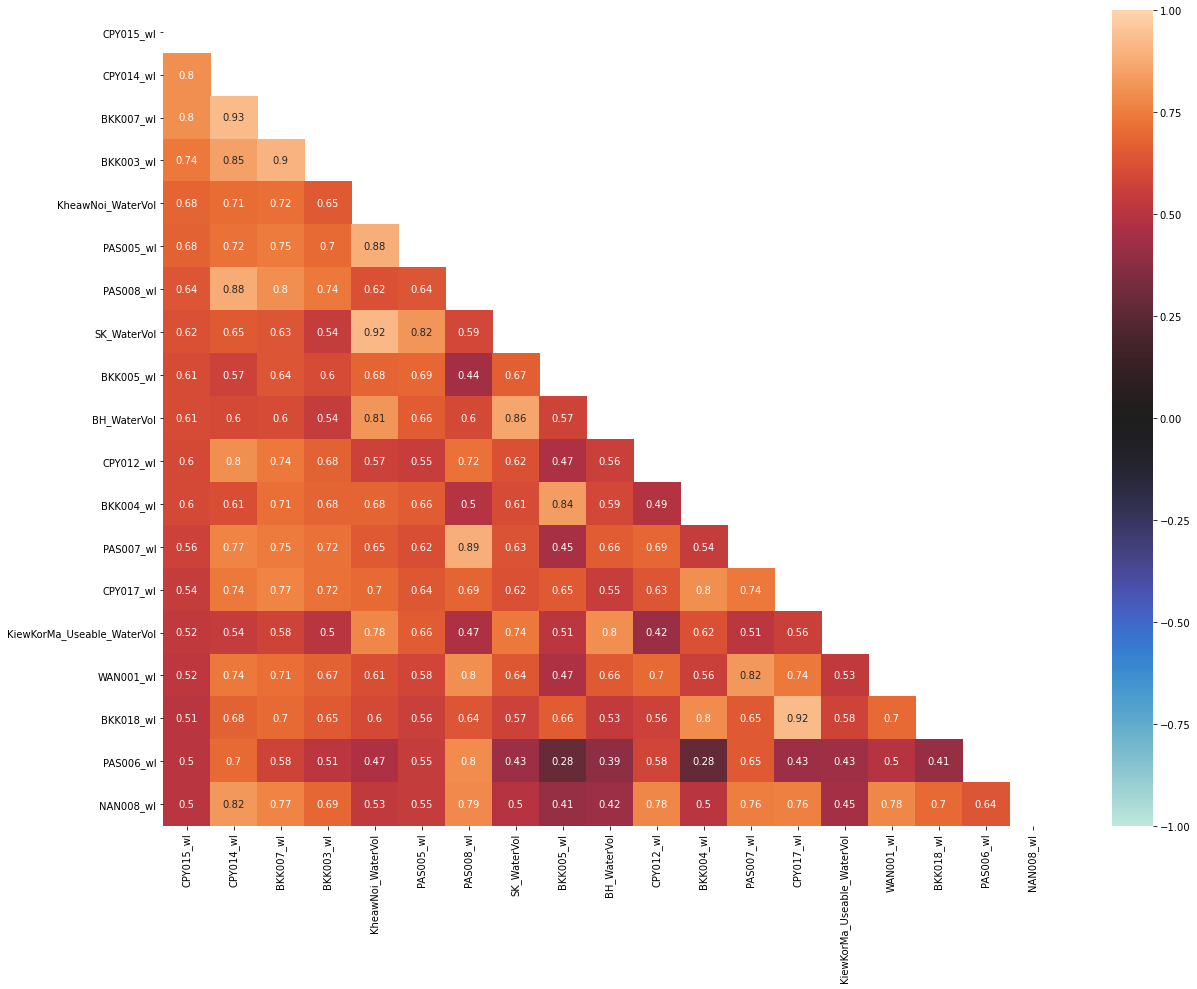

In [73]:
high_col = high_corr(data.iloc[:,1:]) #exclude target it own
data.drop(columns=high_col,inplace=True)
corr = data.corr()
# ax = sns.heatmap(
#     corr, annot = True, fmt='.1g',
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# )
plt.subplots(figsize=(20,15))
mask = np.triu(data.corr())
sns.heatmap(data.corr(), annot = True, vmin=-1, vmax=1, center= 0,mask=mask)
plt.savefig('output/Linear/Corr.png', dpi=300, bbox_inches='tight')

# Linear Regression

In [90]:
X = data.drop(columns=[TARGET]).interpolate(limit=500)
Y = data[TARGET].interpolate(limit=500)

trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, shuffle=False)

In [91]:
regr = linear_model.LinearRegression()
regr.fit(trainX,trainY)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 0.27487292249321843
Coefficients: 
 [ 4.39733997e-01  1.88448372e-01  1.18961843e-01  1.16767392e-04
 -1.00185596e-02 -4.41112873e-02 -3.63600040e-06  1.16380792e-01
  6.86157897e-05  9.45413366e-03  3.54464403e-02  1.76888351e-03
 -3.38772865e-02 -1.00624795e-03  9.72450010e-04  2.18560673e-02
  8.52159546e-03 -2.24566582e-02]


In [92]:
# with statsmodels
#X = sm.add_constant(trainX) # adding a constant
 
#model = sm.OLS(trainY, trainX).fit()
#predictions = model.predict(trainX) 
#model.summary()

# Evaluation

In [93]:
trainPredict = regr.predict(trainX)
train_set_mse = (mean_squared_error(trainY, trainPredict))
train_set_r2 = r2_score(trainY, trainPredict)
print(train_set_mse)
print(train_set_r2)

testPredict = regr.predict(testX)
test_set_mse = ((mean_squared_error(testY, testPredict)))
test_set_r2 = r2_score(testY, testPredict)
print(test_set_mse)
print(test_set_r2)


mse, nse,r2 = real_eva_error(trainY, trainPredict)
Tmse, Tnse,Tr2 = real_eva_error(testY, testPredict)

0.01064838772842554
0.7628203803950928
0.030325574854360254
0.4752715619680683


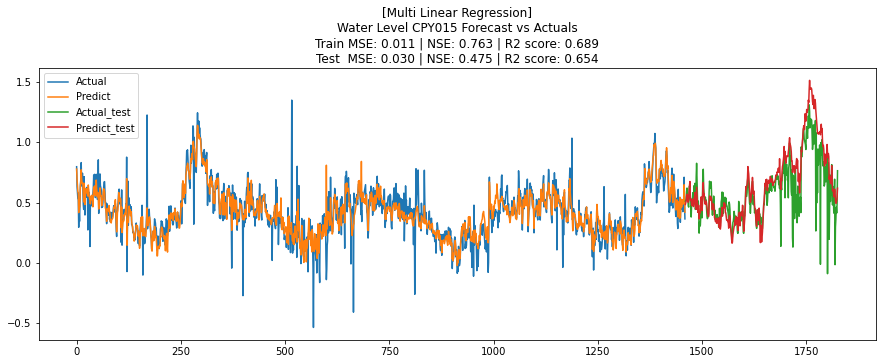

In [94]:
index = np.arange(len(trainY)+len(testY))

Y= pd.Series(data=trainY.values,index=index[:len(trainY)])
Yhat = pd.Series(data=(trainPredict),index=index[:len(trainY)])
Y_t= pd.Series(data=testY.values,index=index[-len(testY):])
Yhat_t = pd.Series(data=(testPredict),index=index[-len(testY):])

plt.figure(figsize=(15,5))
plt.plot(Y, label = "Actual")
plt.plot(Yhat, label = "Predict")

plt.plot(Y_t, label = "Actual_test")
plt.plot(Yhat_t, label = "Predict_test")
plt.title('[Multi Linear Regression]\nWater Level CPY015 Forecast vs Actuals\n'+'Train MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (mse,nse,r2)+'\nTest  MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (Tmse,Tnse,Tr2))
plt.savefig('output/Linear/result_Linear.png', dpi=300, bbox_inches='tight')
plt.legend()
plt.show()

# fig,ax = plt.subplots(2,1,figsize=(20,5),constrained_layout=True)
# ax[0].plot(Y,label="Actual")
# ax[0].plot(Yhat,label="Predict")
# ax[0].set_ylabel('Water level(mm)')
# ax[0].legend()

# ax[1].plot(Y_t,label="Actual")
# ax[1].plot(Yhat_t,label="Predict")
# ax[1].set_ylabel('Water level(mm)')
# ax[1].legend()

# plt.show()
# plt.savefig('output/Linear_fig.png')

In [85]:
trainPredict = pd.Series(data=trainPredict,index=trainY.index)
testPredict = pd.Series(data=testPredict,index=testY.index)

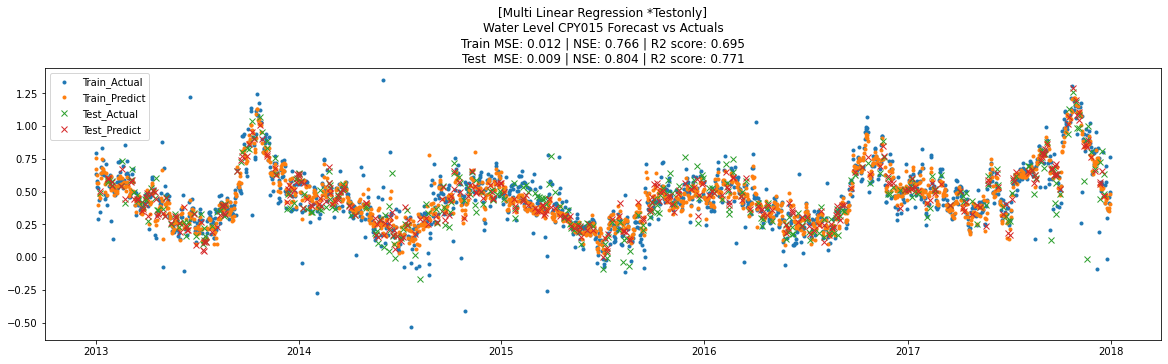

In [89]:
plt.figure(figsize=(20,5))
plt.plot(trainY.sort_index(),'.',label="Train_Actual")
plt.plot(trainPredict.sort_index(),'.',label="Train_Predict")
plt.plot(testY.sort_index(),'x',label="Test_Actual")
plt.plot(testPredict.sort_index(),'x',label="Test_Predict")
plt.title('[Multi Linear Regression *Testonly]\nWater Level CPY015 Forecast vs Actuals\n'+'Train MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (mse,nse,r2)+'\nTest  MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (Tmse,Tnse,Tr2))
plt.savefig('output/Linear/result_Linear.png', dpi=300, bbox_inches='tight')
plt.legend()
plt.show()

In [49]:
mse_train,nse_train,r2_train = real_eva_error(trainPredict,trainY.values)
mse_test,nse_test,r2_test = real_eva_error(testPredict,testY.values)
print("MSE.........|.......NSE")
print(mse_train,"|",nse_train,"|",r2_train)
print(mse_test,"|",nse_test,"|",r2_test)


MSE.........|.......NSE
0.01064838772842554 | 0.6890754026760877 | 0.7628203803950928
0.030325574854360254 | 0.6540868332924301 | 0.4752715619680683


In [16]:
Rec = pd.DataFrame()
Rec = error_rec(Rec,'Multivari_LinearRegression',list(col_feature),"all","None",mse_train,mse_test,nse_train,nse_test,mse_train,mse_test,nse_train,nse_test)
Rec.to_csv('output/Linear/result.csv')